# Linear Regression Implementation from Scratch

We will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Construct an artificial dataset
according to a linear model with additive noise.
The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$$

In [3]:
class SyntheticRegressionData(d2l.DataModule):  
    def __init__(self, w, b, num_examples=1000, batch_size=8):
        super().__init__()
        self.save_hyperparameters()
        self.X = torch.normal(0, 1, (num_examples, len(w)))
        y = torch.matmul(self.X, w) + b + torch.normal(
            0, 0.01, (num_examples,))
        self.y = y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
data = SyntheticRegressionData(true_w, true_b)

Each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar)

In [4]:
print('features:', data.X[0], '\nlabel:', data.y[0])

features: tensor([0.3004, 1.0070]) 
label: tensor([1.3526])


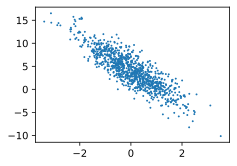

In [5]:
d2l.set_figsize()
d2l.plt.scatter(data.X[:, (1)].detach().numpy(),
                data.y.detach().numpy(), 1);

Define the `data_iter` function
that
takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`

In [7]:
@d2l.add_to_class(SyntheticRegressionData)
def train_dataloader(self):
    indices = list(range(self.num_examples))
    random.shuffle(indices)
    for i in range(0, self.num_examples, self.batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + self.batch_size, self.num_examples)])
        yield self.X[batch_indices], self.y[batch_indices]

for X, y in data.train_dataloader():
    print(X, '\n', y)
    break

tensor([[ 0.9533, -0.3408],
        [-0.4556,  1.3210],
        [ 1.4592,  0.6887],
        [-1.0365,  0.9928],
        [-0.0448, -0.4579],
        [-0.3443,  0.4785],
        [-0.7816, -0.0856],
        [-0.7104, -0.6800]]) 
 tensor([[ 7.2566],
        [-1.2080],
        [ 4.7880],
        [-1.2548],
        [ 5.6563],
        [ 1.8850],
        [ 2.9355],
        [ 5.0925]])


Before we can begin optimizing our model's parameters
we need to have some parameters in the first place

In [8]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, 0.01, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

Define our model,
relating its inputs and parameters to its outputs

In [9]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

Updating our model requires taking
the gradient of our loss function,
define the loss function first

In [11]:
def mse(y_hat, y):  
    """Squared loss."""
    loss = (y_hat - y.reshape(y_hat.shape))**2 / 2
    return loss.mean()

@d2l.add_to_class(LinearRegressionScratch)
def training_step(self, batch, batch_idx):
    X, y = batch
    l = mse(self(X), y)
    self.board.draw({'step': batch_idx, 'loss': l}, every_n=10)
    return l

Despite linear regression has a closed-form solution, other models in this book don't. Here we introduce minibatch stochastic gradient descent

In [13]:
class SGD(d2l.HyperParameters):  
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

Implement the main training loop

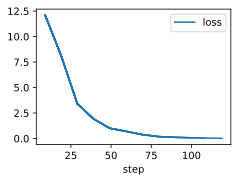

In [15]:
@d2l.add_to_class(d2l.Trainer)
def fit(self, model, data):
    train_dataloader = data.train_dataloader()
    self.train_batch_idx = 0
    optim = model.configure_optimizers()
    for epoch in range(self.max_epochs):
        for batch in train_dataloader:
            loss = model.training_step(batch, self.train_batch_idx)
            optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                optim.step()
            self.train_batch_idx += 1

model = LinearRegressionScratch(2, 1, lr=0.03)
trainer = d2l.Trainer(3)
trainer.fit(model, data)

Evaluate our success in training
by comparing the true parameters
with those that we learned

In [16]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0540, -0.0851], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0974], grad_fn=<RsubBackward1>)


In [20]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2